<a href="https://colab.research.google.com/github/tdiggelm/nn-experiments/blob/master/attention_sequential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [381]:
from keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.corpus import movie_reviews
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from scipy import stats
from keras import activations
from keras import backend as K
from keras import optimizers
from keras import datasets
from IPython.core.display import HTML
from sklearn.metrics import classification_report
!pip install keras-tcn
from tcn import TCN

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# best param: lr = None, clipnorm = 0.1, bs = 16

In [0]:
MAX_SEQ_LEN = 250
#MAX_NUM_WORDS = 10000

(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data()

X_train = pad_sequences(X_train, MAX_SEQ_LEN)
X_test = pad_sequences(X_test, MAX_SEQ_LEN)

word_index = datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2

index_word = {}
for k,v in word_index.items():
  index_word[v] = k

In [0]:
import os
from keras import initializers
from keras import layers
def get_glove_embedding(word_index, input_length=None, trainable=True):
  if not os.path.isfile("glove.6B.100d.txt"):
    !wget "http://nlp.stanford.edu/data/glove.6B.zip"
    !unzip "glove.6B.zip"

  # get glove coeff matrix
  embeddings_index = {}
  with open("glove.6B.100d.txt", encoding="utf-8") as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs
  print('Found %s word vectors.' % len(embeddings_index))

  # prepare pre-learned embedding matrix
  embdedding_dim = 100
  #num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
  num_words = len(word_index) + 1
  embedding_matrix = np.zeros((num_words, embdedding_dim))
  for word, i in word_index.items():
      #if i > MAX_NUM_WORDS:
      #    continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector

  return layers.Embedding(num_words, embdedding_dim, 
                   input_length=input_length, 
                   embeddings_initializer=initializers.Constant(embedding_matrix),
                   trainable=trainable)

In [0]:
def reg(weight_matrix):
  A = K.softmax(weight_matrix, axis=1)
  AT = K.transpose(A)
  M = K.dot(A, AT)
  d = K.shape(M)[1]
  return 1.0 * K.sum(K.abs(M-K.eye(d))**2)

In [503]:
da = 350
r = 30
dropout = 0.2

n_dilations = 8
n_hidden = 128
kernel_size = 3


inputs = layers.Input(shape=(MAX_SEQ_LEN,))
#embedding = layers.Embedding(len(tokenizer.index_word)+1, 100)(inputs)
embedding = get_glove_embedding(word_index)(inputs)
#H = layers.Bidirectional(layers.LSTM(50, return_sequences=True))(embedding)
H = TCN(return_sequences=True,
        dilations=[2**n for n in range(n_dilations)],
        nb_filters=n_hidden,
        kernel_size=kernel_size,
        dropout_rate=dropout)(embedding)

#--- BEGIN ATTENTION (arXiv:1703.03130)
WS1 = layers.Dense(da, activation='tanh')(H)
WS1 = layers.Dropout(dropout)(WS1)
WS2 = layers.Dense(r, kernel_regularizer=reg)(WS1)
WS2 = layers.Dropout(dropout)(WS2)
A = layers.Softmax(axis=1)(WS2)
M = layers.Dot(axes=1)([A, H])
#--- END ATTENTION

reduced = layers.Lambda(lambda x: K.mean(x, axis=1))(M)
dense = layers.Dense(1024, activation='relu')(reduced)
dense = layers.Dropout(dropout)(dense)
dense = layers.Dense(1024, activation='relu')(dense)
dense = layers.Dropout(dropout)(dense)
output = layers.Dense(1, activation='sigmoid')(dense)
model = models.Model(inputs, output)
optimizer = optimizers.Adam(lr=0.002, clipnorm=0.4)
model.compile(optimizer=optimizer, loss=['binary_crossentropy'],
              metrics=['accuracy'])
model.summary()

Found 400000 word vectors.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 250, 100)     8858800     input_99[0][0]                   
__________________________________________________________________________________________________
tcn_initial_conv (Conv1D)       (None, 250, 128)     12928       embedding_76[0][0]               
__________________________________________________________________________________________________
tcn_d_causal_conv_1_tanh_s0 (Co (None, 250, 128)     49280       tcn_initial_conv[0][0]           
__________________________________________________________________________________

In [504]:
history = model.fit(X_train, y_train, validation_data=(X_test[:1000], y_test[:1000]),
                    epochs=3, verbose=1, batch_size=32)

Train on 25000 samples, validate on 1000 samples
Epoch 1/3
25000/25000 [==============================] - 102s 4ms/step - loss: 450.6692 - acc: 0.7934 - val_loss: 435.0786 - val_acc: 0.6860
Epoch 2/3
25000/25000 [==============================] - 73s 3ms/step - loss: 434.1078 - acc: 0.8862 - val_loss: 434.1114 - val_acc: 0.8530
Epoch 3/3
25000/25000 [==============================] - 73s 3ms/step - loss: 433.9641 - acc: 0.9296 - val_loss: 434.2124 - val_acc: 0.8300


In [505]:
y_pred = model.predict(X_test, verbose=1)
print(classification_report(y_test, y_pred>0.5))

25000/25000 [==============================] - 29s 1ms/step
              precision    recall  f1-score   support

           0       0.76      0.94      0.84     12500
           1       0.92      0.70      0.80     12500

   micro avg       0.82      0.82      0.82     25000
   macro avg       0.84      0.82      0.82     25000
weighted avg       0.84      0.82      0.82     25000



Text(0.5, 0, 'epoch')

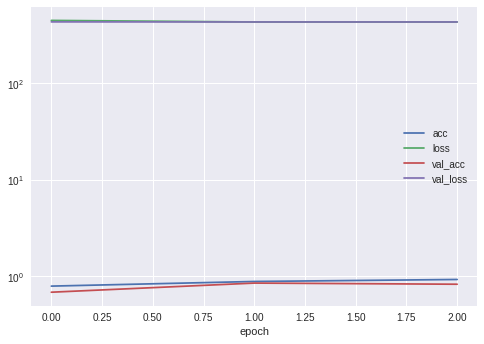

In [506]:
ax = pd.DataFrame(history.history).plot(logy=True)
ax.set_xlabel("epoch")

In [0]:
def highlight_sentence(index_word, seqs, atts, y_true, y_pred, r='mean'):
  html = ''
  for seq, attention, yt, yp in zip(seqs, atts, y_true, y_pred):
    begin = (seq>0).argmax()
    mean_att = None
    if r == 'mean':
      mean_att = attention.mean(axis=1)
    else:
      mean_att = attention[:, r]
    renorm = mean_att[begin:]/mean_att[begin:].max()
    para = ''
    for idx, score in zip(seq[begin:], renorm):
      word = ''
      try:
        word = index_word[idx]
      except KeyError:
        pass
      para += '<span style="background-color: rgba(100%%,0%%,0%%,%d%%)">%s</span> ' % ((score)*100, word)
    titel = '<h3>label (true/prediction): %d/%d</h3>' % (yt, yt)
    html += titel + '<p>' + para + '</p>'
  return html

In [514]:
start = 50
n = 10
X = X_test[start:start+n]
y_true = y_test[start:start+n]
y_pred = model.predict(X)>0.5

HTML(highlight_sentence(index_word, X, model_att.predict(X), y_true, y_pred, r='sum'))